**TME2 FAURE Guillaume et LUCAS Garance** et Mathis K

In [1]:
#!pip install -U dice-ml
#!pip install torch

**Import**

In [121]:
import numpy as np
import math as m
import sklearn as sk
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy as cp
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import dice_ml 
from dice_ml.utils import helpers
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Création dataset

In [20]:
def creation_dataset(n_samples,shuffle, noise, proportion):
    X, y = make_moons(n_samples=n_samples, shuffle = shuffle, noise=noise)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=proportion)
    assemblage = np.hstack((X_train, y_train.reshape(-1,1)))
    train_pd = pd.DataFrame(assemblage, columns= ["x0", "x1","outcome"])
    test_pd = pd.DataFrame(X_test, columns= ["x0", "x1"])
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test)
    return X_train, X_test, y_train, y_test, train_pd, test_pd, X_train_t, y_train_t, X_test_t, y_test_t

In [21]:
X_train, X_test, y_train, y_test, train_pd, test_pd, X_train_t, y_train_t, X_test_t, y_test_t = creation_dataset(1000, True, 0.05,0.3)

# Implémentation d'un Régression logistique format torch

In [5]:
# Créer un modèle de régression logistique simple
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = 2
model = LogisticRegressionModel(input_dim)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Entraîner le modèle
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Époque [{epoch+1}/{num_epochs}], Perte: {loss.item()}')

# Évaluer le modèle sur des données de test
X_test_t = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()

Époque [100/1000], Perte: 0.3954233229160309
Époque [200/1000], Perte: 0.32870444655418396
Époque [300/1000], Perte: 0.3003889322280884
Époque [400/1000], Perte: 0.2835988402366638
Époque [500/1000], Perte: 0.2722148299217224
Époque [600/1000], Perte: 0.26396945118904114
Époque [700/1000], Perte: 0.2577591836452484
Époque [800/1000], Perte: 0.2529539167881012
Époque [900/1000], Perte: 0.24915823340415955
Époque [1000/1000], Perte: 0.24610891938209534


# fonction pour faciliter l'usage de DICE

In [147]:
def dice_train(dataframe, continuous_features,outcome_name, model, backend):
    d = dice_ml.Data(dataframe=dataframe, continuous_features=continuous_features, outcome_name=outcome_name)
    m = dice_ml.Model(model=model, backend=backend)
    exp = dice_ml.Dice(d, m)
    return exp

def dice_test(query_instance, exp, total_CFs, desired_class):
    counterfact = exp.generate_counterfactuals(query_instance, total_CFs=total_CFs, desired_class=desired_class)
    return counterfact

def visualize_table(counterfact, only_change):
    return counterfact.visualize_as_dataframe(show_only_changes= only_change)

def visualize_plot(counterfact,X_train_t, X_test_t, y_train_t, model):
    plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
    x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
    y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Frontière de décision')
    plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'r.')
    points = counterfact.cf_examples_list[0].final_cfs_df.to_numpy()
    plt.plot(points[:, 0], points[:, 1], 'k.')
    plt.show()
    return 

# DICE sur régression logistique

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:11<00:00, 11.96s/it]

Query instance (original outcome : 0)


,x0,x1,outcome
0,0.012698,0.381173,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,0.012698421556417788,-0.53266934141,1.0
1,1.33365559554,0.38117281620403975,1.0
2,1.28453554251,0.0982439409,1.0
3,0.71950830156,-0.56025353895,1.0
4,0.35495551162,0.15641465259,1.0
5,0.012698421556417788,-0.26550361576,1.0
6,1.04192393384,0.23828073565,1.0
7,1.32209791047,0.38117281620403975,1.0
8,1.54944669448,0.44189891563999173,1.0
9,1.65397157911,0.38117281620403975,1.0


None


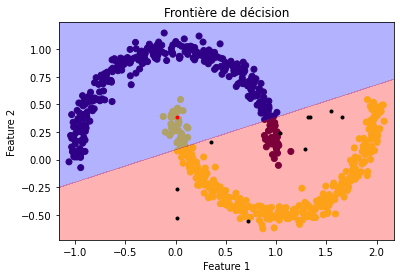

In [7]:
dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
dice_te = dice_test(test_pd[0:1], dice_tr,10, desired_class= "opposite")
print(visualize_table(dice_te, True))
visualize_plot(dice_te, X_train_t, X_test_t, y_train_t, model)

# Implémentation d'un reseau de neurones sur Pytorch 

In [22]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
input_dim = X_train_t.shape[1]
model = SimpleNN(input_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# Évaluer le modèle sur des données de test
with torch.no_grad():
    predicted = model(X_test_t)
    predicted_class = (predicted >= 0.5).float()

Epoch [100/5000], Loss: 0.4227
Epoch [200/5000], Loss: 0.2903
Epoch [300/5000], Loss: 0.2339
Epoch [400/5000], Loss: 0.2007
Epoch [500/5000], Loss: 0.1751
Epoch [600/5000], Loss: 0.1525
Epoch [700/5000], Loss: 0.1311
Epoch [800/5000], Loss: 0.1105
Epoch [900/5000], Loss: 0.0918
Epoch [1000/5000], Loss: 0.0754
Epoch [1100/5000], Loss: 0.0617
Epoch [1200/5000], Loss: 0.0505
Epoch [1300/5000], Loss: 0.0416
Epoch [1400/5000], Loss: 0.0345
Epoch [1500/5000], Loss: 0.0289
Epoch [1600/5000], Loss: 0.0245
Epoch [1700/5000], Loss: 0.0209
Epoch [1800/5000], Loss: 0.0180
Epoch [1900/5000], Loss: 0.0156
Epoch [2000/5000], Loss: 0.0136
Epoch [2100/5000], Loss: 0.0118
Epoch [2200/5000], Loss: 0.0104
Epoch [2300/5000], Loss: 0.0092
Epoch [2400/5000], Loss: 0.0081
Epoch [2500/5000], Loss: 0.0073
Epoch [2600/5000], Loss: 0.0065
Epoch [2700/5000], Loss: 0.0059
Epoch [2800/5000], Loss: 0.0053
Epoch [2900/5000], Loss: 0.0048
Epoch [3000/5000], Loss: 0.0044
Epoch [3100/5000], Loss: 0.0040
Epoch [3200/5000]

# DICE sur NN

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:22<00:00,  5.57s/it]

Query instance (original outcome : 0)


,x0,x1,outcome
0,-0.940487,0.134617,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,-0.3755470575,0.13461676182164856,1.0
1,2.0699689991,0.13461676182164856,1.0
2,1.5242877299,0.13461676182164856,1.0
3,0.2206596586,0.13461676182164856,1.0
4,-0.9404865213888254,-0.49059087459,1.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.91215,-0.555357,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,-0.3528529133,0.56797309304,0.0
1,-0.8946142888,-0.14797643325,0.0
2,1.6521362822,0.667786972,0.0
3,-0.2730138025,0.6124456079,0.0
4,-0.6413147032,0.56716314846,0.0


Query instance (original outcome : 1)


,x0,x1,outcome
0,0.70812,-0.345051,1



Diverse Counterfactual set (new outcome: 0.0)


,x0,x1,outcome
0,0.7081196527380801,0.09233688331,0.0
1,0.7081196527380801,0.58987359601,0.0
2,0.7081196527380801,0.42950063457,0.0
3,0.7081196527380801,0.786793608,0.0
4,0.7081196527380801,0.74269185816,0.0


Query instance (original outcome : 0)


,x0,x1,outcome
0,0.180238,0.950103,0



Diverse Counterfactual set (new outcome: 1.0)


,x0,x1,outcome
0,0.1802384166969314,0.0078621827,1.0
1,0.20271065439991726,0.45184835478,1.0
2,0.2812064593999173,-0.52057863963,1.0
3,0.1802384166969314,0.07377664937,1.0
4,1.8744763336,-0.2464481494,1.0


None


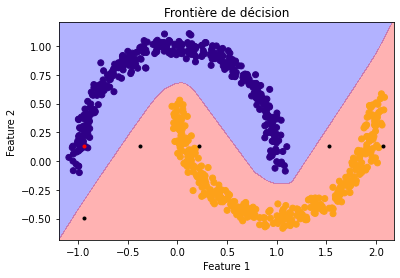

In [140]:
dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
query = test_pd[0:4]
dice_te = dice_test(query, dice_tr, 5 , desired_class= "opposite")
print(visualize_table(dice_te,True))
visualize_plot(dice_te, X_train_t, X_test_t, y_train_t, model)

# Implémentation de critères d'évaluations

**Validity**

Fraction of examples returned by a method that are actually counterfactuals

In [141]:
def prediction_class(model, X_test_t):
    with torch.no_grad():
        predicted = model(X_test_t)
        predicted_class = (predicted >= 0.5).float()
    return predicted_class

def validity(dice_te, prediction, total_cfs):
    w=0
    for i in range(len(prediction)):
        q = np.ones(total_cfs) * np.array(prediction.reshape(-1)[i])
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[:,-1].reshape(-1)
        w += np.sum(np.where(q!=sol,1,0))

    return w/(len(prediction) * total_cfs)

In [142]:
prediction = prediction_class(model,X_test_t[0:4])
print(validity(dice_te, prediction, 5))

1.0


**continuous_Proximity**

mean of feature-wise distances between the CF example and the original input

$$continuous_proximity = - \frac{1}{k}\sum_{i=1}^{k}\frac{1}{d}\sum_{p=1}^{d}\frac{\mid c^p-x^p \mid}{MAD_p}$$

In [105]:
import scipy.stats as st
def continuous_proximity(dice_te, query, X_train):
    norma =[]
    for i in range(len(query)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        norm = 0
        for j in range(0,len(sol)):
            for k in range(0,len(sol[j])):
                norm += np.abs(sol[j][k]-query[i][k]) / (st.median_abs_deviation(X_train, axis=0)[k])
        norma.append(-norm /(query.shape[1]*len(sol)))
    return norma

In [106]:
continuous_proximity(dice_te, X_test[0:3], X_train)

[-1.9365367162122626, -2.0290837278329894, -1.506874017620643]

**proximité catégorielle**

Pour la proximité categorielle qui n'est pas nécessaire dans cet exemple n'ayant que des valeurs continues, on attribue 1 si la dimension est de la meme classe sinon 0.

In [107]:
def categorial_proximity(dice_te, query):
    n = query.shape[1]
    norma =[]
    for i in range(len(query)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        norm = 0
        for j in range(len(sol)):
            for k in range(len(sol[j])):
                d += np.sum(np.where(sol[j][k] != query[i][k], 1, 0))
            
        norma.append(1 - (d / (len(sol)*len(query))))
    return norma

**Parcimonie**

number of changes between the original input and a generated counterfactual

$$parcimonie = 1 - \frac{1}{kd}\sum_{i=1}^{k}\sum_{l=1}^{d}1_{(c_i^l-x_i^p)}$$

Plus la parcimonie est proche de 1 moins il y a eu de changement effectué dans les dimensions

In [102]:
def parcimonie(dice_te, query):
    tot = [] 
    for i in range(len(query)):
        sol = dice_te.cf_examples_list[i].final_cfs_df.to_numpy()[: , 0:-1]
        x = query[i].reshape(1,-1)
        d = 0
        for j in range(len(sol)):
            d += (sol[j] != x).sum()
        tot.append(1 - (d/(len(sol)*len(query))))

    return tot

In [103]:
parcimonie(dice_te, X_test[0:2])

[0.4, 0.25]

Dice propose aussi 2 critères local feature importance et la flobal feature importance

Local feature importance scores

In [16]:
query = test_pd[0:1]
imp = dice_tr.local_feature_importance(query, total_CFs=100)
print(imp.local_importance)

100%|██████████| 1/1 [01:32<00:00, 92.16s/it]

[{'x0': 0.8, 'x1': 0.58}]


Global feature importance scores

In [168]:
query_instances = test_pd[0:10]
imp = dice_tr.global_feature_importance(query_instances)
print(imp.summary_importance)

  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

# Observation de l'evolution lors de l'évolution des paramètres

In [164]:
def dice_train(dataframe, continuous_features,outcome_name, model, backend):
    d = dice_ml.Data(dataframe=dataframe, continuous_features=continuous_features, outcome_name=outcome_name)
    m = dice_ml.Model(model=model, backend=backend)
    exp = dice_ml.Dice(d, m)
    return exp

def dice_test(query_instance, exp, total_CFs, desired_class, proximityweight=0.5, diversityweight=1.0, featurestovary="all", permittedrange=None, posthocsparsityparam=0.1):
    counterfact = exp.generate_counterfactuals(query_instance, total_CFs=total_CFs, desired_class=desired_class, proximity_weight=proximityweight, diversity_weight=diversityweight, features_to_vary=featurestovary, permitted_range=permittedrange, posthoc_sparsity_param=posthocsparsityparam)
    return counterfact

def visualize_table(counterfact, only_change):
    return counterfact.visualize_as_dataframe(show_only_changes= only_change)

def visualize_plot(counterfact,X_train_t, X_test_t, y_train_t, model):
    plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train_t)
    x_min, x_max = X_train_t[:, 0].min() - 0.1, X_train_t[:, 0].max() + 0.1
    y_min, y_max = X_train_t[:, 1].min() - 0.1, X_train_t[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z.detach().numpy(), levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.3)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Frontière de décision')
    plt.plot(X_test_t[0, 0], X_test_t[0, 1], 'r.')
    points = counterfact.cf_examples_list[0].final_cfs_df.to_numpy()
    plt.plot(points[:, 0], points[:, 1], 'k.')
    plt.show()
    return 

Validité en fonction 

In [170]:
dice_tr = dice_train(train_pd, ['x0','x1'] , 'outcome', model, "PYT")
query = test_pd[0:5]
dice_t= []
prediction = []
validi= []
prox = []
parc = []
for i in range(2,11,2):
    dice_te = dice_test(query, dice_tr,  i , desired_class= "opposite")
    dice_t.append(dice_te)
    pred = prediction_class(model, X_test_t[0:5])
    prediction.append(pred)
    val = validity(dice_te, pred, i)
    validi.append(val)
    prox.append(continuous_proximity(dice_te, X_test[0:5], X_train))
    parc.append(parcimonie(dice_te, X_test[0:5]))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:43<00:00, 20.67s/it]


In [173]:
dice_t2= []
prediction2 = []
validi2= []
prox2 = []
parc2 = []
for i in range(2,11,2):
    dice_te2 = dice_test(query, dice_tr,  i , desired_class= "opposite", proximityweight=0.01)
    dice_t2.append(dice_te2)
    prediction2=prediction_class(model, X_test_t[0:5])
    validi2.append(validity(dice_te2, prediction2, i))
    prox2.append(continuous_proximity(dice_te2, X_test[0:5], X_train))
    parc2.append(parcimonie(dice_te2, X_test[0:5]))

100%|██████████| 5/5 [01:14<00:00, 14.83s/it]


In [175]:
dice_t3= []
prediction3 = []
validi3= []
prox3 = []
parc3 = []
for i in range(2,11,2):
    dice_te3 = dice_test(query, dice_tr,  i , desired_class= "opposite", proximityweight=0.99)
    dice_t3.append(dice_te3)
    prediction3=prediction_class(model, X_test_t[0:5])
    validi3.append(validity(dice_te3, prediction3, i))
    prox3.append(continuous_proximity(dice_te3, X_test[0:5], X_train))
    parc3.append(parcimonie(dice_te3, X_test[0:5]))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:15<00:00, 15.16s/it]


In [ ]:
dice_t4= []
prediction4 = []
validi4= []
prox4 = []
parc4 = []
for i in range(2,11,2):
    dice_te4 = dice_test(query, dice_tr,  i , desired_class= "opposite", featurestovary=["x1"])
    dice_t4.append(dice_te4)
    prediction4=prediction_class(model, X_test_t[0:5])
    validi4.append(validity(dice_te4, prediction4, i))
    prox4.append(continuous_proximity(dice_te4, X_test[0:5], X_train))
    parc4.append(parcimonie(dice_te4, X_test[0:5]))

In [ ]:
dice_t5 = []
prediction5 = []
validi5= []
prox5 = []
parc5 = []
for i in range(2,11,2):
    dice_te5 = dice_test(query, dice_tr,  i , desired_class= "opposite", featurestovary=["x1"])
    dice_t5.append(dice_te5)
    prediction5=prediction_class(model, X_test_t[0:5])
    validi5.append(validity(dice_te4, prediction5, i))
    prox5.append(continuous_proximity(dice_te5, X_test[0:5], X_train))
    parc5.append(parcimonie(dice_te5, X_test[0:5]))

[[0.8, 0.7, 0.7, 0.7, 0.7], [0.8, 0.8, 0.75, 0.65, 0.75], [0.7333333333333334, 0.8, 0.6666666666666667, 0.7333333333333334, 0.7666666666666666], [0.725, 0.7, 0.75, 0.725, 0.725], [0.76, 0.72, 0.72, 0.72, 0.6599999999999999]]


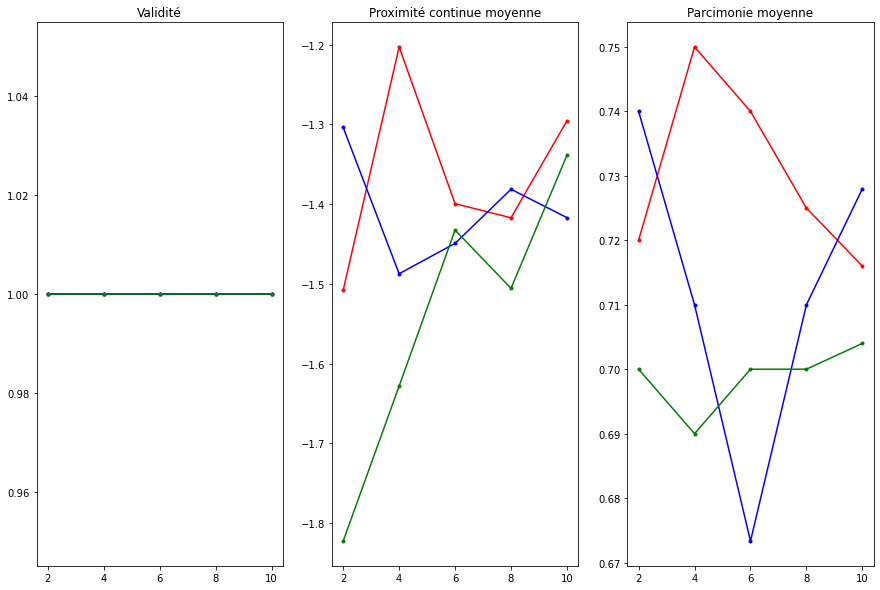

In [177]:
axe = [2,4,6,8,10]
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
plt.plot(axe, validi, 'r.-')
plt.plot(axe, validi2, 'b.-')
plt.plot(axe, validi3, 'g.-')
plt.plot(axe, validi4, 'y.-')
plt.plot(axe, validi5, 'm.-')
plt.title("Validité")
plt.subplot(1,3,2)
plt.plot(axe, [np.array(prox[i]).sum()/len(prox[i]) for i in range(len(prox))], 'r.-')
plt.plot(axe, [np.array(prox2[i]).sum()/len(prox2[i]) for i in range(len(prox2))], 'b.-')
plt.plot(axe, [np.array(prox3[i]).sum()/len(prox3[i]) for i in range(len(prox3))], 'g.-')
plt.plot(axe, [np.array(prox4[i]).sum()/len(prox4[i]) for i in range(len(prox4))], 'y.-')
plt.plot(axe, [np.array(prox5[i]).sum()/len(prox5[i]) for i in range(len(prox5))], 'm.-')
plt.title("Proximité continue moyenne")
plt.subplot(1,3,3)
plt.plot(axe, [np.array(parc[i]).sum()/len(parc[i]) for i in range(len(parc))], 'r.-')
plt.plot(axe, [np.array(parc2[i]).sum()/len(parc2[i]) for i in range(len(parc2))], 'b.-')
plt.plot(axe, [np.array(parc3[i]).sum()/len(parc3[i]) for i in range(len(parc3))], 'g.-')
plt.plot(axe, [np.array(parc4[i]).sum()/len(parc4[i]) for i in range(len(parc4))], 'y.-')
plt.plot(axe, [np.array(parc5[i]).sum()/len(parc5[i]) for i in range(len(parc5))], 'm.-')
plt.title("Parcimonie moyenne")
plt.show()

# DICE sur autre donnée

In [18]:
dataset =helpers.load_adult_income_dataset()
target = dataset['income']
train_dataset, test_dataset, _, _ = train_test_split(dataset, target, test_size=0.2, random_state=0,stratify=target)

# initialise DiCE
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age','hours_per_week'], outcome_name='income') 

m= dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(), backend='TF2',func ="ohe-min-max")
exp = dice_ml.Dice(d,m)
# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

2023-10-04 21:14:53.311951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 21:14:55.352655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-04 21:14:57.507263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-04 21:14:57.731704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-04 21:14:57.731779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,85.0,1
1,29,Private,Bachelors,Married,Blue-Collar,White,Female,51.0,1
2,67.0,Private,Bachelors,Married,Blue-Collar,White,Female,38,1
3,76.0,Private,HS-grad,Married,Blue-Collar,White,Female,84.0,1
